# How data informs variance posteriors

Let's consider the simple Gaussian noise model

\begin{equation*}
    y \sim \mathcal{N}(y^s, \sigma ^2_y),
\end{equation*}

where $y_s$ are the predictions of the structural model and $\sigma _y$ captures the fluctations of the observations around $y^s$ that we may expect due to measurement noise or uncaptured biological processes. In other words, our error model is to assume a $y^s$ independent base level noise parameterised by $\sigma ^2_y$.

In this notebook we want to understand how observations transform priors for $\sigma ^2_y$ into the final posterior distribution. This will enable us to make better informed prior probability choices for Bayesian inference.

For simplicity, let's assume the structural model is known, such that the inference is only concerned with $\sigma ^2_y$. If we then choose a inverse-gamma prior for $\sigma ^2_y$ with the probability density

\begin{equation*}
    f(\sigma ^2; \alpha, \beta ) = \frac{\beta ^{\alpha}}{\Gamma (\alpha )}\left( \frac{1}{x}\right)^{\alpha + 1}\exp \left( -\frac{\beta}{x}\right) ,
\end{equation*}

one can show that the posterior probability distribution of $\sigma ^2_y$ is also given by an inverse-gamma distribution $f(\sigma ^2; \alpha ', \beta ')$, where the parameters $\alpha '$ and $\beta '$ are functions of the observations $y^{\text{obs}}=\{ y^{\text{obs}}_1, y^{\text{obs}}_2, \ldots , y^{\text{obs}}_n\}$ and the hyperparameters of the prior $\alpha, \beta$

\begin{equation*}
    \alpha ' = \alpha + \frac{n}{2}, \quad \beta ' = \beta + \frac{\sum _{i=1}^n\left( y^{\text{obs}}_i-y^s_i\right) ^2}{2}.
\end{equation*}

It can further be derived that the resulting posterior predictive distribution is given by a Student's t distribution

\begin{equation*}
    t_{\nu }(y | \mu, \sigma ^2) = \frac{\Gamma \left( \frac{\nu + 1}{2}\right)}{\sqrt{\nu \pi}\, \Gamma \left( \frac{\nu}{2}\right)}\left( 1+\frac{(y-\mu)^2}{\nu\sigma^2}\right) ^{-\frac{\nu +1}{2}},
\end{equation*}

where the degrees of freedom are $\nu = 2\alpha '$, the mean is $\mu = y^s$, and the standard deviation is given by $\sigma ^2=\beta '/ \alpha '$.

## The true model

Let's imagine the true noise was given by 

\begin{equation*}
    \epsilon \sim \mathcal{N}(0, \sigma ^2_y = 100),
\end{equation*}

such that $y = y^s + \epsilon $. 

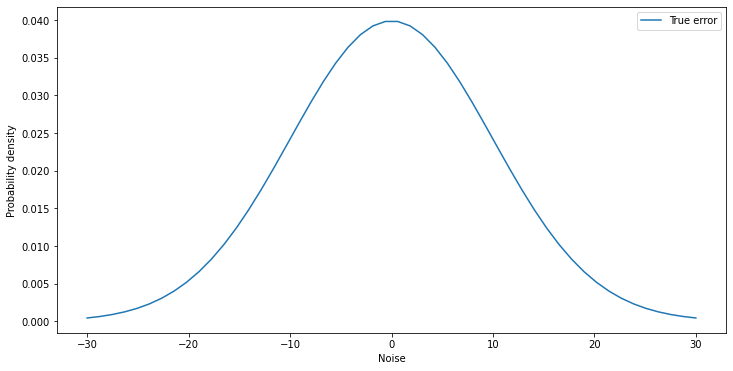

In [1]:
#
# Illustration of true noise
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define true sigma
sigma = 10

# Compute pdf for from range [-30, 30]
samples = np.linspace(-30, 30)
pdf = norm.pdf(samples, loc=0, scale=sigma)

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf, label='True error')

# X and Y label
plt.xlabel('Noise')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

## Generating observations for the inference

We can now generate some data by drawing samples from the noise model.

In [2]:
#
# Generating data from true noise model.
#

from scipy.stats import norm

# True standard deviation
sigma = 10

# Number of observations
n = 1000

# Seeding generator for reproducibility
np.random.seed(42)

# Generate data
data = norm.rvs(loc=0, scale=sigma, size=n) 

## Defining prior distribution for $\sigma ^2_y$

Let's first define a largely non-informative prior by tuning the hyperparameters $\alpha $ and $\beta $, such that the 99th percentile of the posterior is at 5000.

99th percentile:  994.9916247342214


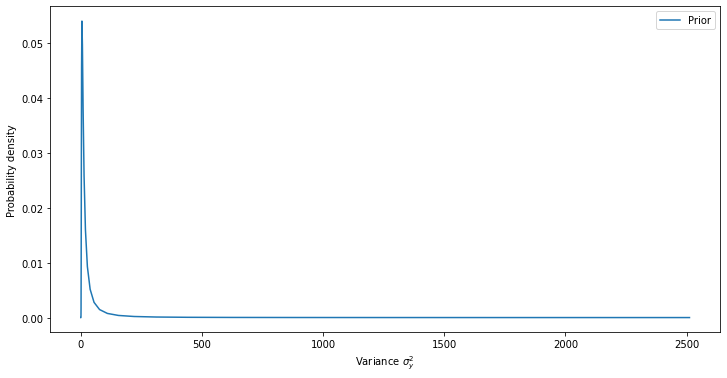

In [3]:
#
# Illustrating prior distribution for sigma ^2_y
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma


# Define hyperparameters
alpha = 1
beta = 10

# Compute 99th percentile
print('99th percentile: ', invgamma.ppf(.99, a=alpha, scale=beta))

# Compute pdf for from range [0, 500]
samples = np.logspace(-4, 3.4)
pdf = invgamma.pdf(samples, a=alpha, scale=beta)  # a=alpha, scale=beta

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf, label='Prior')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

We can see that the prior distribution is heavily peaked for small values of $\sigma ^2_y$, but largely flat for values greater than 50. Intuitively one might hope that too small values $\sigma ^2_y$ can be easily outruled from the a significantly larger spread of the data. The strong peak may therefore not be a problem. Let's convince ourselves that that is the case by learning the posterior predictive model from 10, 100, and 1000 observations.

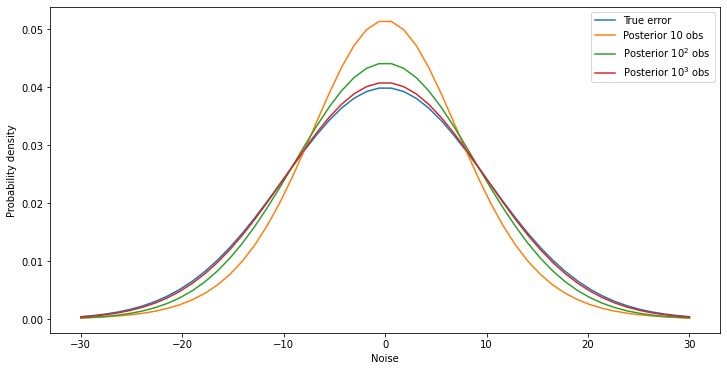

In [4]:
#
# Generate data from the true error model and illustrate posterior predictive models inferred from the data.
#
# This cell needs the previously simulated data.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t


# Define convenience functions to compute posterior parameters from data
def alpha_prime(data, alpha, beta):
    """
    Returns the posterior parameter alpha'.

    Arguments:
        data -- Noise observations.
        alpha -- Prior hyperparameter.
        beta -- Prior hyperparameter. 
    """
    # Number of observations
    n = len(data)

    return alpha + n / 2

def beta_prime(data, alpha, beta):
    """
    Returns the posterior parameter beta'.

    Arguments:
        data -- Noise observations.
        alpha -- Prior hyperparameter.
        beta -- Prior hyperparameter. 
    """
    return beta + np.sum(data ** 2) / 2

# Define prior hyperparameters
alpha = 1
beta = 10

# Compute posterior parameters for 10, 100, 1000 observations
alpha_10 = alpha_prime(data[:10], alpha, beta)
beta_10 = beta_prime(data[:10], alpha, beta)

alpha_100 = alpha_prime(data[:100], alpha, beta)
beta_100 = beta_prime(data[:100], alpha, beta)

alpha_1000 = alpha_prime(data[:1000], alpha, beta)
beta_1000 = beta_prime(data[:1000], alpha, beta)

# Define true sigma
sigma = 10

# Compute pdf of true error model for from range [-30, 30]
samples = np.linspace(-30, 30)
pdf_true = norm.pdf(samples, loc=0, scale=sigma)

# Compute pdf of posterior predictive model for from range [-30, 30]
# 10 observations
samples = np.linspace(-30, 30)
pdf_10 = t.pdf(samples, df=2*alpha_10, loc=0, scale=np.sqrt(beta_10/alpha_10))

# 100 observations
samples = np.linspace(-30, 30)
pdf_100 = t.pdf(samples, df=2*alpha_100, loc=0, scale=np.sqrt(beta_100/alpha_100))

# 1000 observations
samples = np.linspace(-30, 30)
pdf_1000 = t.pdf(samples, df=2*alpha_1000, loc=0, scale=np.sqrt(beta_1000/alpha_1000))

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf_true, label='True error')
plt.plot(samples, pdf_10, label=r'Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel('Noise')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

After learning from 1000 observations the posterior predictive model is pretty close to the true error model. However, it seems that the posteriors are biased towards smaller variances. The question is whether this is due to our prior choice, or a property of the data.

We can assess this in two ways:

1. We can compute the variances of the data that were used to train the posteriors and compare it to the true variance $\sigma ^2_y=100$.
2. We can explore how the observations shape the posteriors after 10, 100 and 1000 observations. 

In [5]:
#
# Compute variances of data for first 10, 100, and 1000 observations.
#
# This cell needs the simulated data.
#

import numpy as np


# Compute variances
var_10 = np.var(data[:10])
var_100 = np.var(data[:100])
var_1000 = np.var(data[:1000])

# Print true variance and data variances
print('True variance: ', sigma ** 2)
print('Variance of first 10 observations: ', var_10)
print('Variance of first 100 observations: ', var_100)
print('Variance of first 1000 observations: ', var_1000)

True variance:  100
Variance of first 10 observations:  47.046694521315665
Variance of first 100 observations:  81.65221946938584
Variance of first 1000 observations:  95.79049897315173


The variances of the data does indeed seem to be less than the true variance. It therefore seems plausible that the posterior predictive models are biased towards smaller variances. This however does not rule out that the prior biases the posteriors towards smaller values of $\sigma ^2_y$. Let's get a feeling for the posterior by plotting it after 10, 100 and 1000 observations.

99th percentile:  994.9916247342214


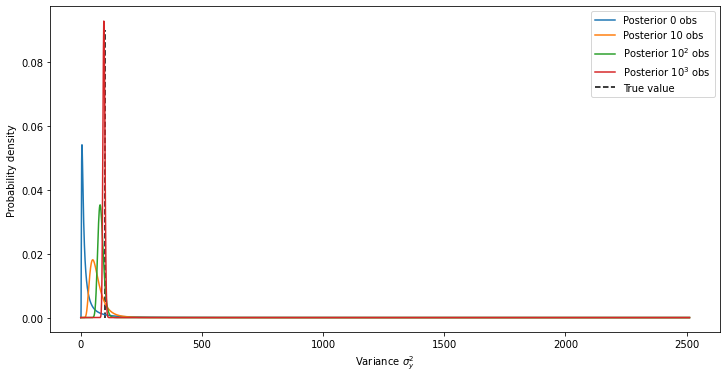

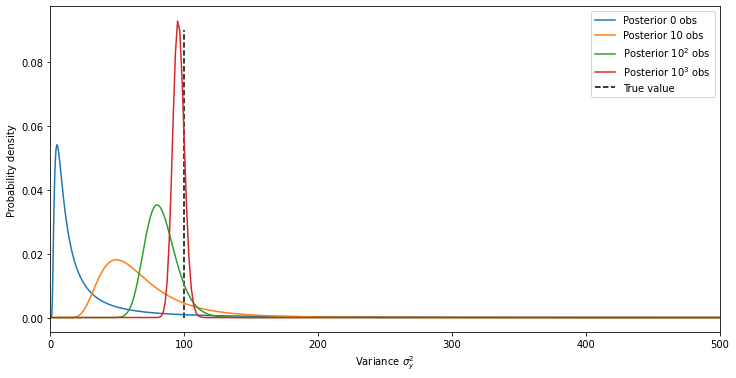

In [6]:
#
# Illustrate how observations transform prior into posterior.
#
# This cell needs the previously computed posterior parameters.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma


# Define hyperparameters
alpha = 1
beta = 10

# Compute 99th percentile
print('99th percentile: ', invgamma.ppf(.99, a=alpha, scale=beta))

# Compute pdfs from range [0, 500]
samples = np.logspace(-4, 3.4, 1000)
pdf_0 = invgamma.pdf(samples, a=alpha, scale=beta)  # a=alpha, scale=beta
pdf_10 = invgamma.pdf(samples, a=alpha_10, scale=beta_10)
pdf_100 = invgamma.pdf(samples, a=alpha_100, scale=beta_100)
pdf_1000 = invgamma.pdf(samples, a=alpha_1000, scale=beta_1000)

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.vlines(x=sigma**2, ymin=0, ymax=0.09, color='black', linestyle='dashed', label='True value')
plt.plot(samples, pdf_0, label='Posterior 0 obs')
plt.plot(samples, pdf_10, label='Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

# Plot PDF Zoom into interesting range
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.vlines(x=sigma**2, ymin=0, ymax=0.09, color='black', linestyle='dashed', label='True value')
plt.plot(samples, pdf_0, label='Posterior 0 obs')
plt.plot(samples, pdf_10, label='Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# X limits
plt.xlim([0, 500])

# Create legend
plt.legend()

# Show plot
plt.show()


There are two things that are interesting to note about how the data shapes the posterior:

1. Although the posterior is biased towards smaller variances, this bias does not seem to originate from the prior but rather from the data. This may be seen by observing that most of the posterior weight is centered around the variances of the data (47, 82, 96 for the first 10, 100, and 1000 observations, respectively), and that the posteriors are not skewed to the right. If the data had difficulties to overcome the heavy peak of the prior for small values of $\sigma ^2_y$ you would expect that the posterior had a bump or a long tail towards smaller values. Instead the left side of all posteriors is very steap, and already after 10 observations there is no trace of the strong peak of the prior.  

2. While the posterior learns to reject too small values for $\sigma ^2_y$ very quickly, it seems to be much harder to reject too large ones. This may be exemplified by the fact that the exponential decay of the prior distribution with growing $\sigma ^2_y$ persists for the first 10 and 100 observations also in the posterior distribution. This skewes the posteriors to the left, and suggests larger variances than actually observed from the data. In this case this skewedness biases the posteriors towards the true variance of the error model.

To understand why the variance posterior has such an easier time to learn too small $\sigma ^2_y$, rather than too big ones, let's have a closer look at how the data and the prior determine the posterior. The posterior distribution $\mathbb{P}(\sigma ^2_y | y^{\text{obs}}; \alpha, \beta)$ is related to the data $\epsilon^{\text{obs}}=\{ \epsilon^{\text{obs}}_1, \epsilon^{\text{obs}}_2, \ldots , \epsilon^{\text{obs}}_n\}$ and the prior $\mathbb{P}(\sigma ^2_y | \alpha, \beta)$ through Bayes' rule

\begin{equation*}
    \log \mathbb{P}(\sigma ^2_y | \epsilon^{\text{obs}}; \alpha, \beta ) =  \sum _{i=1}^n\log \mathbb{P}(\epsilon | \sigma ^2_y ) \Big| _{\epsilon=\epsilon^{\text{obs}}_i} + \log \mathbb{P}(\sigma ^2_y | \alpha, \beta ) + \text{constant},
\end{equation*}

where $\mathbb{P}(\epsilon | \sigma ^2_y )\Big| _{\epsilon=\epsilon^{\text{obs}}_i}=\mathcal{N}(0, \sigma ^2_y)\Big| _{\epsilon=\epsilon^{\text{obs}}_i}$ is the likelihood of the parameter $\sigma ^2_y$ for a fixed observation $\epsilon=\epsilon^{\text{obs}}_i $. In other words, the likelihood may also be interpreted as the probability with which the observation $\epsilon^{\text{obs}}_i$ would be generated by the noise model $\mathcal{N}(0, \sigma ^2_y)$ for a given $\sigma ^2_y$. The prior is given by the inverse-gamma function $\mathbb{P}(\sigma ^2_y | \alpha, \beta ) = f(\sigma ^2_y | \alpha, \beta )$. Note that this means that each individual term on the right hand side of the equation assumes values in $(-\infty, 0]$. In particular, the terms assume values close to $-\infty $ if the probabilities are close to zero, and values close to zero if the probabilities are close to one. 

This shows that very small probabilities for a given $\sigma ^2_y$, either from the likelihood or the prior, will dominate the contributions to it's posterior probability, even if the remaining terms suggest high likelihood of said parameter value. This may provide the intuition that data shapes the posterior not so much by focussing on good parameter values, but rather by drastically penalising unlikely ones.

This explains why the posterior weight is so easily shifted away from small values for $\sigma ^2_y$. Any observation whose deviation from the center of the Normal distribution is larger than 4-fold of a given $\sigma ^2_y$ will immediately lead to a close to zero posterior probability of that parameter. In contrast, too large values for $\sigma ^2_y$ are much harder to reject based on observations. This is because for any value for $\sigma ^2_y$ the Normal distribution will have it's peak at zero. As a result, only ridiculously widely spread Normal distributions contribute with disqualifyingly little likelihood to the posterior. However, variances that are only a couple fold larger than the variance observed in the data will still receive likelihood contributions that will be of the same order of magnitude. It therefore takes many more observations to gradually set the true $\sigma ^2_y$ apart from too large values. This intuition may be supported by looking at how the posterior transform by learning from each observation one by one.

In [7]:
#
# Slider animation: How data shapes the posterior.
#
# This cell needs the definition of the functions alpha_prime and beta_prime.
#

from ipywidgets import *
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import invgamma, norm, t


def compute_likelihood(data, sigmas):
    """
    Computes the likelihoods of the sigmas for each given data point.
    """
    # Initalise container for likelihoods
    likelihood = np.empty(shape=(len(data), len(sigmas)))

    # Compute likelihood of each sigma
    for ids, s in enumerate(sigmas):
        likelihood[:, ids] = norm.pdf(data, loc=0, scale=s)
    
    return likelihood

# Define true sigma
sigma = 10

# Define prior hyperparameters
alpha_0 = 1
beta_0 = 10

# Number observations
n = len(data)

# Define container for alpha and beta after # observations
alpha = np.empty(shape=n+1)
beta = np.empty(shape=n+1)

# Compute posterior parameters
for num_obs in range(n+1): 
    alpha[num_obs] = alpha_prime(data[:num_obs], alpha_0, beta_0)
    beta[num_obs] = beta_prime(data[:num_obs], alpha_0, beta_0)

# Define samples for posterior predictive model
samples_pred = np.linspace(-30, 30, 1000)

# Define container for posteriors
predictive = np.empty(shape=(n+1, 1000))

# Compute pdfs from range [0, 500]
for num_obs in range(n+1):
    predictive[num_obs, :] = t.pdf(samples_pred, df=2*alpha[num_obs], loc=0, scale=np.sqrt(beta[num_obs]/alpha[num_obs]))

# Define samples for posterior
samples_post = np.logspace(-4, 2.7, 1000)

# Define container for posteriors
posterior = np.empty(shape=(n+1, 1000))

# Compute pdfs from range
for num_obs in range(n+1):
    posterior[num_obs, :] = invgamma.pdf(samples_post, a=alpha[num_obs], scale=beta[num_obs])

# Define container for likelihoods
likelihood = np.empty(shape=(n, 1000))

# Compute likelihood
likelihood = compute_likelihood(data=data, sigmas=np.sqrt(samples_post))

# Create plot of prior
# Create figure
fig = make_subplots(rows=2, cols=1)
fig = go.FigureWidget(fig)

# Plot true error model, prior predictive model and initial posterior predictive model
fig.add_trace(
    go.Scatter(
        x=samples_pred, y=norm.pdf(samples_pred, loc=0, scale=sigma), mode="lines", name='True model', 
        line = dict(color='black', dash='dash')),
    row=1,
    col=1)
fig.add_trace(
    go.Scatter(
        x=samples_pred, y=predictive[0], mode="lines", name='Prior predictive model', 
        line = dict(color='grey')),
    row=1,
    col=1)
fig.add_trace(
    go.Scatter(
        x=samples_pred, y=predictive[0], mode="lines", name='Posterior predictive model', 
        line = dict(color='blue')),
    row=1,
    col=1)

# Plot place holder scatter plot for added data point
fig.add_trace(
    go.Scatter(
        x=[], y=[0], mode="markers", name='Posterior predictive model', 
        line = dict(color='red')),
    row=1,
    col=1)

# Create X and Y label
fig.update_xaxes(title_text=r'$\text{Noise } \epsilon$', row=1, col=1)
fig.update_yaxes(title_text=r'$\text{Probability density}$', row=1, col=1)

# Plot true sigma, prior and initial posterior
# True sigma as vertical line
fig.add_trace(
    go.Scatter(
        x=[sigma**2, sigma**2], y=[0, 0.09], mode="lines", name='True value', 
        line = dict(color='black', dash='dash')),
    row=2,
    col=1)
fig.add_trace(
    go.Scatter(x=samples_post, y=posterior[0], mode="lines", name='Prior',
    line = dict(color='grey')),
    row=2,
    col=1)
fig.add_trace(
    go.Scatter(x=samples_post, y=posterior[0], mode="lines", name='Posterior',
    line = dict(color='blue')),
    row=2,
    col=1)

# Plot place holder line plot for likelihoods for given data point
fig.add_trace(
    go.Scatter(
        x=samples_post, y=[], mode="lines", name='Likelihoods for added data point', 
        line = dict(color='red')),
    row=2,
    col=1)

# Create X and Y label
fig.update_xaxes(title_text=r'$\text{Variance }\sigma ^2_y$', row=2, col=1)
fig.update_yaxes(title_text=r'$\text{Probability density}$', row=2, col=1)

# Create legend
fig.update_layout(showlegend=True, height=700)

@interact(num_obs=(0, n, 1))
def update(num_obs=0):
    """
    Helper function to update the posterior, posterior predictive distribution 
    and the newly added data point and it's likelihood according to the number
    of observations num_obs.
    """
    with fig.batch_update():
        # Update posterior predictive model
        pred = fig.data[2]
        pred.y = predictive[num_obs, :]

        # Update recently added data point
        point = fig.data[3]
        if num_obs == 0:
            point.x = []
        else:
            point.x = [data[num_obs-1]]

        # Update posterior
        post = fig.data[-2]
        post.y = posterior[num_obs, :]

        # Update likelihood
        lh = fig.data[-1]
        if num_obs == 0:
            lh.y = []
        else:
            lh.y = likelihood[num_obs-1]

display(fig)

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash'},
              'mode': 'lines',
      …